In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import sklearn.metrics as metrics
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./kaggle_data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# These are the manually picked columns that are all categorical
total_categorical_cols = ['MSZoning', 'Street', 'Alley', 'LandContour', 
                    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'ExterCond', 'Foundation', 'Heating', 'CentralAir', 'PavedDrive',
                    'MiscFeature', 'SaleType', 'SaleCondition']

# These columns will have to be manually processed
total_rating_cols = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

#########
# Below will be the columns actually used in the model
#########

category_cols = ['SaleType']
rating_cols = ['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu']
continuous_cols = ['OverallQual']

In [4]:
# Take rating columns and convert to numerical scale
rating_df = df.copy()[rating_cols]

replace_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,
               'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4,
               'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1,
               'Gtl': 1, 'Mod': 2, 'Sev': 3,
               'NA': 0,
               'Av': 3, 'Mn': 2, 'No': 1,
               'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
               'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1,
               'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1,
               '2Types': 6, 'Attchd': 5, 'Basment': 4, 'BuiltIn': 3, 'CarPort': 2, 'Detchd': 1,
               'Fin': 3, 'RFn': 2, 'Unf': 1,
               'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}

rating_df.replace(replace_dict, inplace=True)

na_to_zero_cols = ['LotShape', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual',
                   'PoolQC', 'Fence', 'Electrical']

na_to_zero_cols = [col for col in na_to_zero_cols if col in rating_df]

rating_df[na_to_zero_cols] = rating_df.loc[:, na_to_zero_cols].fillna(0)

In [5]:
# Select categorical columns and get dummy column values (different approach from what we did before with category type)
# Preferably pick columns that are not like rating columns (Bad, Okay, Great). We should handle those separately
dummy_df = pd.get_dummies(df[category_cols])

In [6]:
YVar = df[['SalePrice']]
XVar = pd.concat([df[continuous_cols], dummy_df, rating_df], axis=1)

# Filter out nan values
YVar = YVar[XVar.notna().all(axis='columns')]
XVar = XVar[XVar.notna().all(axis='columns')]

print('Num rows after filtering out nans: ' + str(len(XVar)))

XVar = XVar.apply(pd.to_numeric)

Num rows after filtering out nans: 1460


In [7]:
# Split data 80-20 so we can test how well the model works
msk = np.random.rand(len(XVar)) < 0.8

train_x = XVar[msk]
train_y = YVar[msk]

test_x = XVar[~msk]
test_y = YVar[~msk]

In [8]:
# Run linear regression with statsmodels to get statistics
sm_linear_model = sm.OLS(train_y, train_x).fit()
print(sm_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     185.2
Date:                Thu, 30 Apr 2020   Prob (F-statistic):          1.67e-284
Time:                        12:44:47   Log-Likelihood:                -14343.
No. Observations:                1183   AIC:                         2.872e+04
Df Residuals:                    1168   BIC:                         2.879e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
OverallQual     2.388e+04   1648.238     14.

In [9]:
# Run linear regression with sklearn
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

# Make predictions using the testing set, then convert to pandas series
saleprice_preds = regr.predict(test_x)
saleprice_preds = pd.Series([x for lst in saleprice_preds for x in lst])

# Print out coefficient information (coefficient of determination is perfect if it is 1)
#print('Coefficients: \n', regr.coef_)
#explained_variance = metrics.explained_variance_score(test_y, saleprice_preds)
#mean_absolute_error = metrics.mean_absolute_error(test_y, saleprice_preds) 
#mse = metrics.mean_squared_error(test_y, saleprice_preds) 
#mean_squared_log_error = metrics.mean_squared_log_error(test_y, saleprice_preds)
#median_absolute_error = metrics.median_absolute_error(test_y, saleprice_preds)
r2 = metrics.r2_score(test_y, saleprice_preds)

print('r2: ', round(r2,4))
#print('explained_variance: ', round(explained_variance,4))    
#print('mean_squared_log_error: ', round(mean_squared_log_error,4))
#print('MAE: ', round(mean_absolute_error,4))
#print('MSE: ', round(mse,4))
#print('RMSE: ', round(np.sqrt(mse),4))

r2:  0.7248


In [10]:
# Construct the results dataframe
actual_price = test_y.reset_index()['SalePrice']
pred_price = saleprice_preds.round()

res = pd.DataFrame({'actual_price': actual_price, 'predicted_price': pred_price})
res

,actual_price,predicted_price
0,208500,211515.0
1,140000,212760.0
2,250000,256833.0
3,118000,143600.0
4,129500,116338.0
...,...,...
272,186500,180397.0
273,174000,205498.0
274,197000,191359.0
275,149300,209074.0


In [11]:
res['residual'] = res.actual_price - res.predicted_price
res['percent_diff'] = (res['residual'] / res.actual_price * 100).round(decimals=2)
res

,actual_price,predicted_price,residual,percent_diff
0,208500,211515.0,-3015.0,-1.45
1,140000,212760.0,-72760.0,-51.97
2,250000,256833.0,-6833.0,-2.73
3,118000,143600.0,-25600.0,-21.69
4,129500,116338.0,13162.0,10.16
...,...,...,...,...
272,186500,180397.0,6103.0,3.27
273,174000,205498.0,-31498.0,-18.10
274,197000,191359.0,5641.0,2.86
275,149300,209074.0,-59774.0,-40.04


In [12]:
print('Average percent_difference: %.2f' % (res.percent_diff.abs().mean()))

Average percent_difference: 18.02


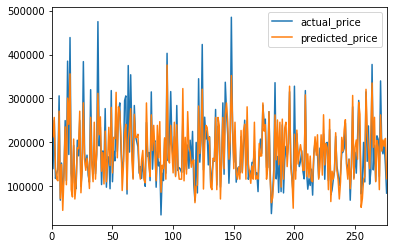

In [14]:
# Predicted price is actually really close to actual, but not when actual price is very very high
res.plot(kind='line', y=['actual_price', 'predicted_price'])

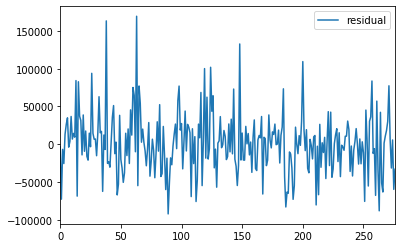

In [15]:
res.plot(kind='line', y='residual')